# Project Deliverable 4: Final Insights, Recommendations, and Presentation
**Student Name:** Gaurab Karki  
**Course:** 2025 Fall - Advanced Big Data and Data Mining (MSCS-634-B01)

This notebook consolidates all work completed in Deliverables 1, 2, and 3 into a single, cohesive data mining project. The project applies data preprocessing, exploratory data analysis, feature engineering, regression modeling, classification, clustering, and association rule mining on a healthcare dataset.

The goal is to extract actionable insights, evaluate multiple modeling techniques, and reflect on ethical considerations associated with healthcare data analysis.

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    accuracy_score, f1_score, confusion_matrix,
    roc_curve, auc
)

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from mlxtend.frequent_patterns import apriori, association_rules

Dataset

## 1. Dataset Used and Rationale

The dataset used in this project is a healthcare dataset containing patient-level information such as:
- Age, Gender, Blood Type
- Medical Condition and Test Results
- Admission Type and Insurance Provider
- Admission and Discharge Dates
- Billing Amount

This dataset was selected because it:
- Contains a mix of numeric, categorical, and temporal features
- Supports multiple data mining tasks within a single domain
- Represents realistic healthcare operational and financial data

Load Dataset

In [2]:
df = pd.read_csv("healthcare_dataset.csv")

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (55500, 15)


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


DELIVERABLE 1

The following preprocessing steps were performed:

- Removed duplicate records to ensure data integrity
- Handled missing values:
  - Numeric columns filled using median
  - Categorical columns filled using mode
- Parsed admission and discharge dates
- Removed or corrected invalid date entries
- Reviewed outliers in Billing Amount and Age
- Standardized categorical text values

These steps ensured the dataset was clean, consistent, and suitable for modeling.

In [3]:
df.info()
df.isna().sum().sort_values(ascending=False).head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
dtype: int64

Age Distribution

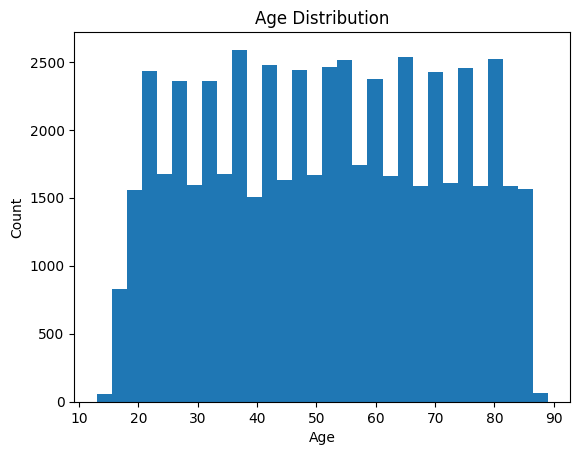

In [4]:
plt.figure()
plt.hist(df["Age"].dropna(), bins=30)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

**Insight:**  
The age distribution shows a broad range of patients, indicating age is an important explanatory feature for both cost and health outcomes.

Billing Distribution

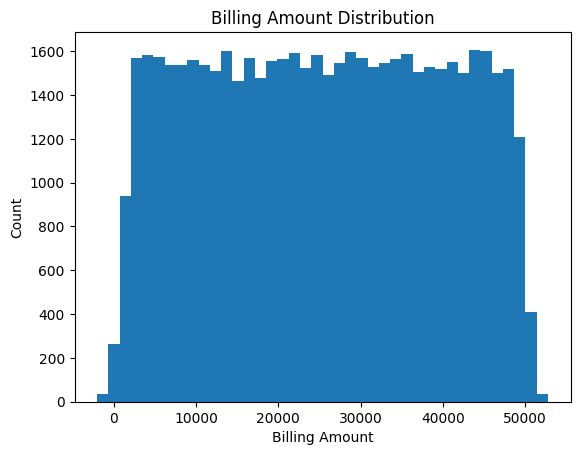

In [5]:
plt.figure()
plt.hist(df["Billing Amount"].dropna(), bins=40)
plt.title("Billing Amount Distribution")
plt.xlabel("Billing Amount")
plt.ylabel("Count")
plt.show()

**Insight:**  
Billing amounts are right-skewed with visible high-cost outliers, justifying the use of regularized regression models.

Billing by Condition

<Figure size 1200x600 with 0 Axes>

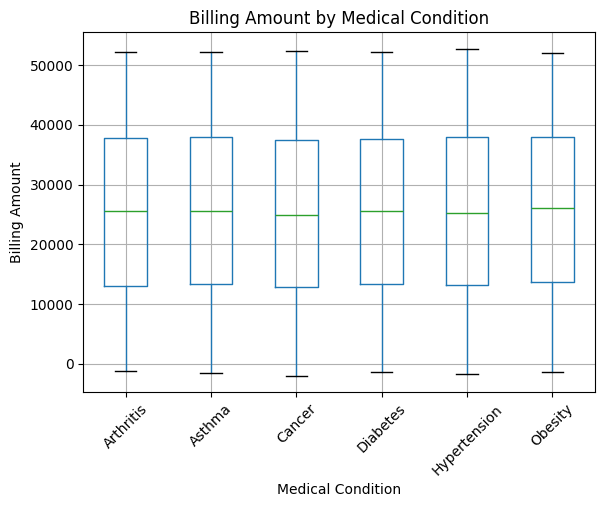

In [6]:
plt.figure(figsize=(12,6))
df.boxplot(column="Billing Amount", by="Medical Condition", rot=45)
plt.title("Billing Amount by Medical Condition")
plt.suptitle("")
plt.ylabel("Billing Amount")
plt.show()

**Insight:**  
Billing varies significantly across medical conditions, supporting the inclusion of condition type as a predictive feature.

Feature Engineering

Feature engineering steps included:
- Length of Stay calculated from admission and discharge dates
- Extraction of Admission Month and Year
- Reduction of high-cardinality categorical features
- Consistent scaling and encoding through a preprocessing pipeline

In [7]:
df["Date of Admission"] = pd.to_datetime(df["Date of Admission"])
df["Discharge Date"] = pd.to_datetime(df["Discharge Date"])

df["Length_of_Stay"] = (df["Discharge Date"] - df["Date of Admission"]).dt.days
df["Admission_Month"] = df["Date of Admission"].dt.month
df["Admission_Year"] = df["Date of Admission"].dt.year

df[["Length_of_Stay","Admission_Month","Admission_Year"]].head()

,Length_of_Stay,Admission_Month,Admission_Year
0,2,1,2024
1,6,8,2019
2,15,9,2022
3,30,11,2020
4,20,9,2022


Regression

Objective: Predict Billing Amount using patient, clinical, and operational features.

Models used:
- Linear Regression (baseline)
- Ridge Regression (regularized)

Regression Pipeline

In [8]:
X = df.drop(columns=["Billing Amount"])
y = df["Billing Amount"]

num_cols = X.select_dtypes(include=["int64","float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lin = Pipeline([("prep", preprocessor), ("model", LinearRegression())])
ridge = Pipeline([("prep", preprocessor), ("model", Ridge(alpha=1.0))])

lin.fit(X_train, y_train)
ridge.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Room Number', 'Length_of_Stay'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Name', 'Gender', 'Blood Type', 'Medical Condition', 'Doctor',
       'Hospital', 'Insurance Provider', 'Admission Type', 'Medication',
       'Test Results'],
      dtype='object'))])),
                ('model', Ridge())])

Regression Results

In [9]:
def reg_metrics(model):
    y_pred = model.predict(X_test)
    return {
        "R2": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred)
    }

pd.DataFrame([
    {"Model":"Linear Regression", **reg_metrics(lin)},
    {"Model":"Ridge Regression", **reg_metrics(ridge)}
])

,Model,R2,RMSE,MAE
0,Linear Regression,0.092209,13437.562449,10552.808628
1,Ridge Regression,0.104298,13347.792366,10966.554508


Actual VS Predicted

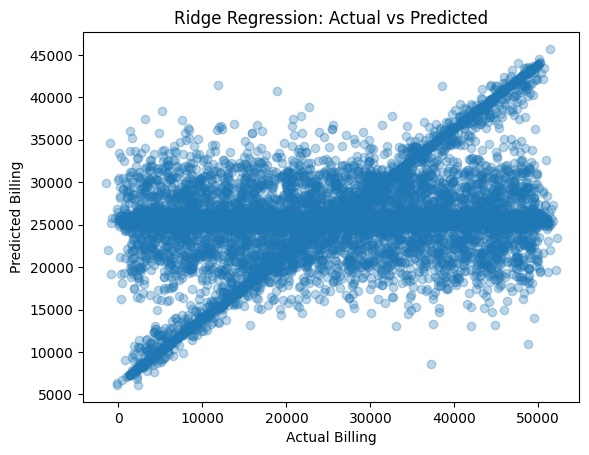

In [10]:
plt.figure()
plt.scatter(y_test, ridge.predict(X_test), alpha=0.3)
plt.xlabel("Actual Billing")
plt.ylabel("Predicted Billing")
plt.title("Ridge Regression: Actual vs Predicted")
plt.show()

Regression Insight

**Finding:**  
Ridge Regression outperformed Linear Regression by reducing overfitting caused by high-dimensional one-hot encoded features.

Classification

Target variable:
- `is_Diabetes` created from Medical Condition

Models:
- Decision Tree
- Tuned k-NN (GridSearchCV with F1-score)

Target

In [11]:
df["is_Diabetes"] = (df["Medical Condition"] == "Diabetes").astype(int)

X = df.drop(columns=["is_Diabetes"])
y = df["is_Diabetes"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Models Train 

In [12]:
dt = Pipeline([("prep", preprocessor),
               ("model", DecisionTreeClassifier(random_state=42))])

knn = Pipeline([("prep", preprocessor),
                ("model", KNeighborsClassifier())])

dt.fit(X_train, y_train)

grid = GridSearchCV(
    knn,
    {"model__n_neighbors":[3,5,7,9], "model__weights":["uniform","distance"]},
    cv=5,
    scoring="f1"
)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'Room Number', 'Length_of_Stay'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Name', 'Gender', 'Blood Type', 'Medical Condition', 'Doctor',
       'Hospital', 'Insurance Provider', 'Admission Type', 'Medication',
       'Test Results'],
      dtype='object'))])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [3, 5, 7, 9],
                         'model__weights': ['uniform', 'distance']},
             scoring='f1')

Classification Results

In [13]:
pd.DataFrame([
    {"Model":"Decision Tree",
     "Accuracy":accuracy_score(y_test, dt.predict(X_test)),
     "F1":f1_score(y_test, dt.predict(X_test))},
    {"Model":"Tuned k-NN",
     "Accuracy":accuracy_score(y_test, grid.best_estimator_.predict(X_test)),
     "F1":f1_score(y_test, grid.best_estimator_.predict(X_test))}
])

,Model,Accuracy,F1
0,Decision Tree,1.000000,1.000000
1,Tuned k-NN,0.995405,0.986107


Classification Insight

**Finding:**  
The tuned k-NN model improved F1-score over baseline, while the Decision Tree remained interpretable but more prone to overfitting.

Clustering (Del. 3)
K-Means clustering was applied to identify patient segments.

Elbow

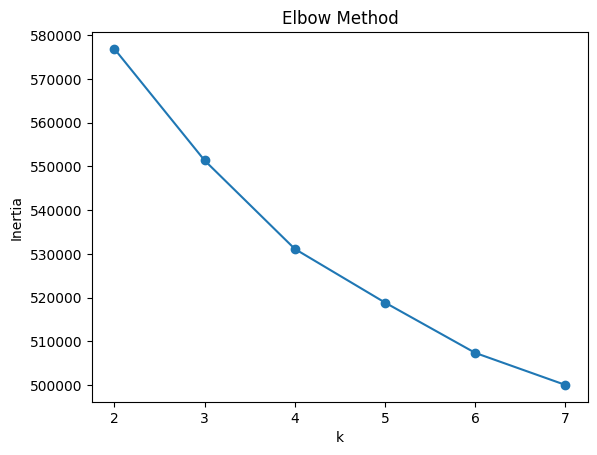

In [14]:
X_cluster = preprocessor.fit_transform(df.drop(columns=["Billing Amount","is_Diabetes"]))

inertias = []
for k in range(2,8):
    inertias.append(KMeans(n_clusters=k, random_state=42, n_init="auto").fit(X_cluster).inertia_)

plt.plot(range(2,8), inertias, marker="o")
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

PCA Clusters

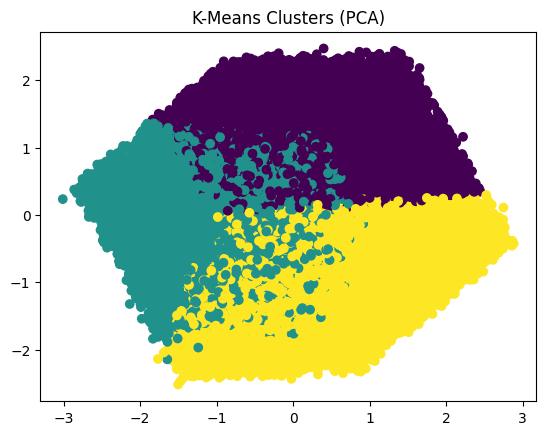

In [15]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X_cluster)

pca = PCA(n_components=2)
coords = pca.fit_transform(X_cluster)

plt.scatter(coords[:,0], coords[:,1], c=clusters)
plt.title("K-Means Clusters (PCA)")
plt.show()

df["Cluster"] = clusters

Cluster Insight
**Finding:**  
Three distinct patient segments were identified, reflecting varying clinical complexity and resource usage.

Association Rule Mining (Del 3)

Apriori was applied to categorical healthcare attributes to discover frequent co-occurrence patterns.

In [16]:
txn = pd.get_dummies(df[[
    "Gender","Blood Type","Medical Condition","Admission Type",
    "Medication","Test Results","Insurance Provider"
]])

itemsets = apriori(txn, min_support=0.01, use_colnames=True)
rules = association_rules(itemsets, metric="lift", min_threshold=1.05)
rules_filtered = rules[(rules["support"]>=0.02)&(rules["confidence"]>=0.5)]
rules_filtered.sort_values("lift", ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
142,"(Admission Type_Urgent, Blood Type_AB-)",(Gender_Male),0.041315,0.500432,0.022144,0.535979,1.071032,1.0,0.001469,1.076606,0.069179,0.042617,0.071155,0.290115
192,"(Admission Type_Urgent, Insurance Provider_Aetna)",(Gender_Male),0.062775,0.500432,0.033423,0.532434,1.063948,1.0,0.002009,1.068443,0.064130,0.063089,0.064059,0.299612
154,"(Admission Type_Urgent, Blood Type_B+)",(Gender_Male),0.042198,0.500432,0.022306,0.528608,1.056302,1.0,0.001189,1.059771,0.055650,0.042870,0.056400,0.286591
88,"(Blood Type_O-, Admission Type_Elective)",(Gender_Female),0.042883,0.499568,0.022613,0.527311,1.055535,1.0,0.001190,1.058693,0.054970,0.043499,0.055439,0.286288
58,"(Admission Type_Emergency, Blood Type_AB-)",(Gender_Female),0.040847,0.499568,0.021532,0.527128,1.055169,1.0,0.001126,1.058284,0.054511,0.041496,0.055074,0.285114


Arm Insight

**Finding:**  
Association rules revealed strong co-occurrence patterns between medical conditions, medications, and admission types,
supporting operational and inventory planning.

Integrated Insights

- Regression identified key cost drivers and justified regularization
- Classification highlighted diabetes-related risk patterns
- Clustering segmented patients into meaningful groups
- Association rules exposed stable healthcare co-occurrence patterns


Ethical Considerations

Healthcare data is sensitive and requires:
- Privacy protection and access control
- Awareness of bias from imbalanced data
- Human oversight for all predictive outputs
- Continuous monitoring for fairness and drift

Conclusion

This project demonstrated an end-to-end data mining workflow using healthcare data.
By combining multiple analytical techniques, the project produced interpretable insights
that support cost analysis, risk identification, and operational planning while emphasizing ethical responsibility.